# Lecture 2: Matvec complexity, fast convolution

## Matrix-by-vector multiplication (matvec)

Multiplication of a matrix $A$ of size $n\times n$ by a vector $x$ of size $n\times 1$:
$$
y_{i} = \sum_{i=1}^n a_{ij} x_j
$$
requires $n^2$ mutliplications and $n(n-1)$ additions. Thus, the overall complexity is $2n^2 - n =$ <font color='red'> $\mathcal{O}(n^2)$ </font>.

## How bad is $\mathcal{O}(n^2)$

To understand how time-consuming $\mathcal{O}(n^2)$ can be consider the following example.
Let $A$ be the matrix of pairwise gravitational interaction between planets in a galaxy.
The number of planets in an average galaxy is $10^{11}$, so the size of this matrix will be $10^{11} \times 10^{11}$.
To model evolution in time we have to multiply this matrix by vector at each time step.
Top supercomputers do around $10^{16}$ floating point operations per second (flops), so the time required to multiply the matrix $A$ by a vector is approximately
$$
\frac{(10^{11})^2 \text{ operations}}{10^{16} \text{ flops}} = 10^6 \text{ sec} \approx 11.5 \text{ days} 
$$
for one time step. If we could multiply it with $\mathcal{O}(n)$ complexity, we would get
$$
\frac{10^{11} \text{ operations}}{10^{16} \text{ flops}} = 10^{-5} \text{ sec}
$$
instead. Fortunately, there is an algorithm to be $\mathcal{O}(n)$ for this particular example.

__Question__: what is the minimal time to multiply by a general matrix $A$?

## Can we beat $\mathcal{O}(n^2)$?

Generally speaking no. The point is that we have $\mathcal{O}(n^2)$ input data, so there is no way to be faster for a general matrix.
Fortunately, we can be faster <font color='red'>for certain types of matrices</font>.
Here are some examples:

* The simplest example may be a matrix of all ones, which can be easily multiplied with only $n-1$ additions. This matrix is of rank one. More generally we can multiply fast by <font color='red'>low-rank </font> matrices (or by matrices that have low-rank blocks)

* <font color='red'>Sparse</font> matrices (contain $\mathcal{O}(n)$ nonzero elements)

* <font color='red'>Structured</font> matrices (later this lecture):
  * Fourier
  * Circulant
  * Toeplitz 
  * Hankel

## Fourier matrix

The Fourier matrix is defined as:
$$
F_n =
\begin{pmatrix}
1 & 1 & 1 & \dots & 1 \\
1 & w^{1\cdot 1}_n & w^{1\cdot 2}_n & \dots & w^{1\cdot (n-1)}_n\\
1 & w^{2\cdot 1}_n & w^{2\cdot 2}_n & \dots & w^{2\cdot (n-1)}_n\\
\dots & \dots & \dots &\dots &\dots \\
1 & w^{(n-1)\cdot 1}_n & w^{(n-1)\cdot 2}_n & \dots & w^{(n-1)\cdot (n-1)}_n\\
\end{pmatrix},
$$
or equivalently
$$
F_n = \{ w_n^{kl} \}_{k,l=0}^{n-1},
$$
where $$w_n = e^{-\frac{2\pi i}{n}}.$$

**Properties:**
* Symmetric
* Unitary up to a scaling factor: $F_n^* F_n = F_n F_n^* = nI$ (__bonus task__ prove this fact). Therefore $F_n^{-1} = \frac{1}{n}F^*_n$
* Can be multiplied by a vector (called dicrete Fourier transform or DFT) with <font color='red'>$\mathcal{O}(n \log n)$</font> complexity (called fast Fourier transform or <font color='red'>FFT</font>)! FFT helps to analyze spectrum of a signal and, as we will see later, helps to do fast mutiplications with certain types of matrices.

Text(0.5, 1.0, 'Initial signal')

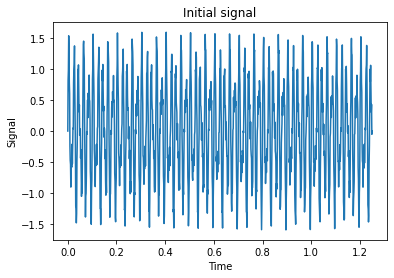

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


N = 1000
dt = 1.0 / 800.0
x = np.linspace(0.0, N*dt, N)
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x) + 0.2*np.sin(300.0 * 2.0*np.pi*x)
plt.plot(x, y)
plt.xlabel('Time')
plt.ylabel('Signal')
plt.title('Initial signal')

Text(0.5, 1.0, 'Discrete Fourier transform')

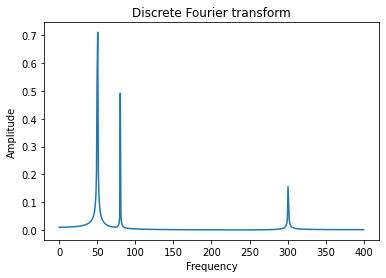

In [2]:
yf = np.fft.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*dt), N//2)
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2])) #Note: N/2 to N will give negative frequencies
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('Discrete Fourier transform')

In [3]:
#FFT vs full matvec
import time
import numpy as np
import scipy as sp
import scipy.linalg

n = 10000
F = sp.linalg.dft(n)
x = np.random.randn(n)

t = time.time()
y_full = F.dot(x)
print('Full matvec time =', time.time() - t)

t = time.time()
y_fft = np.fft.fft(x)
print('FFT time =', time.time() - t)

print('Relative error =', (np.linalg.norm(y_full - y_fft)) / np.linalg.norm(y_full))

Full matvec time = 0.0664670467376709
FFT time = 0.0007450580596923828
Relative error = 1.550401887243687e-12


## Circulant matrices



FFT can help to multiply fast by certain types of matrices. We start from a circulant matrix:

$$
C =
\begin{pmatrix} 
c_0 & c_{n-1} & c_{n-2} & \dots & c_1 \\
c_{1} & c_{0} & c_{n-1} & \dots & c_2 \\
c_{2} & c_{1} & c_0 & \dots & c_3 \\
\dots & \dots & \dots & \dots & \dots \\
c_{n-1} & c_{n-2} & c_{n-3} & \dots & c_0
\end{pmatrix}
$$

**Theorem.** 
Let $C$ be a circulant matrix of size $n\times n$ and let $c$ be it's first column , then
$$
C = \frac{1}{n} F_n^* \text{diag}(F_n c) F_n 
$$

#### Fast matvec with circulant matrix

Representation $C = \frac{1}{n} F^* \text{diag}(F_n c) F_n $ gives us an explicit way to multiply a vector $x$ by $C$ in $\mathcal{O}(n\log n)$ operations. Indeed,
$$
Cx = \frac{1}{n} F_n^* \text{diag}(F_n c) F_n x = \text{ifft}\left( \text{fft}(c) \circ \text{fft}(x)\right)
$$
where $\circ$ denotes elementwise product (Hadamard product) of two vectors (since $\text{diag}(a)b = a\circ b$) and ifft denotes inverse Fourier transform $F^{-1}_n$.

In [5]:
import time
import numpy as np
import scipy as sp
import scipy.linalg

def circulant_matvec(c, x):
    return np.fft.ifft(np.fft.fft(c) * np.fft.fft(x))

n = 10000
c = np.random.random(n)
C = sp.linalg.circulant(c)
x = np.random.randn(n)

t = time.time()
y_full = C.dot(x)
print('Full matvec time =', time.time() - t)

t = time.time()
y_fft = circulant_matvec(c, x)
print('FFT time =', time.time() - t)

print('Relative error =', (np.linalg.norm(y_full - y_fft)) / np.linalg.norm(y_full))

Full matvec time = 0.029829978942871094
FFT time = 0.0012180805206298828
Relative error = 1.4544774168028043e-15


## Toeplitz matrices

Another example where FFT can help us with the fast matvec operation is a Toeplitz matrix (diagonal constant matrix):
$$
T =
\begin{pmatrix} 
t_0 & t_{-1} & t_{-2} & t_{-3}& \dots & t_{1-n} \\
t_{1} & t_{0} & t_{-1} & t_{-2}& \dots & t_{2-n} \\
t_{2} & t_{1} & t_0 & t_{-1} &\dots & t_{3-n} \\
t_{3} & t_{2} & t_1 & t_0 & \dots & t_{4-n} \\
\dots & \dots & \dots & \dots & \dots & \dots\\
t_{n-1} & t_{n-2} & t_{n-3} & t_{n-4} &\dots &t_0
\end{pmatrix},
$$
or equivalently $T_{ij} = t_{i-j}$.

Matvec operation can be written as
$$
y_i = \sum_{j=1}^n t_{i-j} x_j,
$$
which can be interpreted as a discrete <font color='red'>convolution</font> of filter $t_i$ and signal $x_i$. 
For simplicity the size of the filter $t$ is such that the sizes of the input and output signals are the same. Generally, filter size can be arbitrary.

Fast convolution computation has a variety of applications, for instance, in signal processing or partial differential and integral equations. For instance, here is the smoothing of a signal:

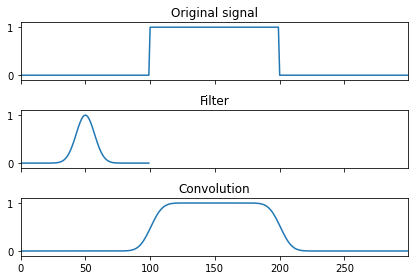

In [6]:
from scipy import signal
alpha = 0.01
sig = np.repeat([0., 1., 0.], 100)
filt = np.exp(-alpha * (np.arange(100)-50)**2)
filtered = signal.convolve(sig, filt, mode='same') / sum(filt)

fig, (ax_orig, ax_filt, ax_filtered) = plt.subplots(3, 1, sharex=True)
ax_orig.plot(sig)
ax_orig.margins(0, 0.1)
ax_filt.plot(filt)
ax_filt.margins(0, 0.1)
ax_filtered.plot(filtered)
ax_filtered.margins(0, 0.1)

ax_orig.set_title('Original signal')
ax_filt.set_title('Filter')
ax_filtered.set_title('Convolution')

fig.tight_layout()

#### Fast matvec with Toeplitz matrix

The multiplication by a Toeplitz matrix can be reduced to the multiplication by a circulant.
Indeed, every Toeplitz matrix of size $n\times n$ can be embedded into a Circulant matrix $C$ of size $2n-1 \times 2n-1$:
$$
C = 
\begin{pmatrix}
T & \dots \\
\dots & \dots
\end{pmatrix}.
$$
The $3\times 3$ matrix $T = \begin{pmatrix} 
t_0 & t_{-1} & t_{-2} \\
t_{1} & t_{0} & t_{-1} \\
t_{2} & t_{1} & t_0 \\
\end{pmatrix}$ 
can be embedded as follows
$$
C = 
\begin{pmatrix} 
t_0 & t_{-1} & t_{-2} & t_{2} & t_{1}\\
t_{1} & t_{0} & t_{-1} & t_{-2} & t_{2} \\
t_{2} & t_{1} & t_0 & t_{-1} & t_{-2} \\
t_{-2}& t_{2} & t_{1} & t_0 & t_{-1}  \\
t_{-1} & t_{-2} & t_{2} & t_{1} & t_0  
\end{pmatrix}.
$$
For matvec 
$ \begin{pmatrix} y_1 \\ y_2 \\ y_3 \end{pmatrix}=
\begin{pmatrix} 
t_0 & t_{-1} & t_{-2} \\
t_{1} & t_{0} & t_{-1} \\
t_{2} & t_{1} & t_0 \\
\end{pmatrix}
\begin{pmatrix} x_1 \\ x_2 \\ x_3 \end{pmatrix}$
we pad vector $x$ with zeros:
$$
\begin{pmatrix} y_1 \\ y_2 \\ y_3 \\ \star \\ \star \end{pmatrix} =
\begin{pmatrix} 
t_0 & t_{-1} & t_{-2} & t_{2} & t_{1}\\
t_{1} & t_{0} & t_{-1} & t_{-2} & t_{2} \\
t_{2} & t_{1} & t_0 & t_{-1} & t_{-2} \\
t_{-2}& t_{2} & t_{1} & t_0 & t_{-1}  \\
t_{-1} & t_{-2} & t_{2} & t_{1} & t_0  
\end{pmatrix}
\begin{pmatrix} x_1 \\ x_2 \\ x_3 \\ 0 \\ 0 \end{pmatrix}=
\text{ifft}(\text{fft}(\begin{pmatrix} t_0 \\ t_{1} \\ t_{2} \\ t_{-2} \\ t_{-1} \end{pmatrix})\circ \text{fft}(\begin{pmatrix} x_1 \\ x_2 \\ x_3 \\ 0 \\ 0 \end{pmatrix})).
$$
Note that you do not need to form and store the whole matrix $T$.

## Multilevel Toeplitz matrices

The 2-dimensional convolution is defined as 
$$
y_{i_1i_2} = \sum_{j_1,j_2=1}^n t_{i_1-j_1, i_2-j_2} x_{j_1 j_2}.
$$
Note that $x$ and $y$ are 2-dimensional arrays and $T$ is 4-dimensional. 
To reduce this expression to matrix-by-vector product we have to reshape $x$ and $y$ into long vectors:
$$
\text{vec}(x) = 
\begin{pmatrix}
x_{11} \\ \vdots \\ x_{1n} \\ \hline \\ \vdots \\ \hline \\ x_{n1} \\ \vdots \\ x_{nn}
\end{pmatrix},
\quad
\text{vec}(y) = 
\begin{pmatrix}
y_{11} \\ \vdots \\ y_{1n} \\ \hline \\ \vdots \\ \hline \\ y_{n1} \\ \vdots \\ y_{nn}
\end{pmatrix}.
$$
In this case matrix $T$ is block Toeplitz with Toeplitz blocks:
$$
T = 
\begin{pmatrix} 
T_0 & T_{-1} & T_{-2} &  \dots & T_{1-n} \\
T_{1} & T_{0} & T_{-1} & \dots & T_{2-n} \\
T_{2} & T_{1} & T_0 & \dots & T_{3-n} \\
\dots & \dots & \dots &  \dots & \dots\\
T_{n-1} & T_{n-2} & T_{n-3}  &\dots &T_0
\end{pmatrix},
\quad \text{where} \quad
T_k = t_{k, i_2 - j_2}\quad  \text{are Toeplitz matrices}
$$

#### Fast matvec with multilevel Toeplitz matrix

To get fast matvec we need to embed block Toeplitz matrix with Toeplitz blocks into the block circulant matrix with circulant blocks. The analog of
$$\begin{pmatrix} y_1 \\ y_2 \\ y_3 \\ \star \\ \star \end{pmatrix} =
\text{ifft}(\text{fft}(\begin{pmatrix} t_0 \\ t_{1} \\ t_{2} \\ t_{-2} \\ t_{-1} \end{pmatrix})\circ\text{fft}(\begin{pmatrix} x_1 \\ x_2 \\ x_3 \\ 0 \\ 0 \end{pmatrix})).$$
will look like
$$ \begin{pmatrix} y_{11} & y_{12} & y_{13} & \star & \star \\ 
y_{21} & y_{22} & y_{23} & \star & \star \\  
y_{31} & y_{32} & y_{33} & \star & \star \\ 
\star & \star & \star & \star & \star \\  
\star & \star & \star & \star & \star \\  
\end{pmatrix} = \text{ifft2d}(\text{fft2d}(\begin{pmatrix} t_{0,0} & t_{1,0} & t_{2,0} & t_{-2,0} & t_{-1,0} \\ 
t_{0,1} & t_{1,1} & t_{2,1} & t_{-2,1} & t_{-1,1} \\  
t_{0,2} & t_{1,2} & t_{2,2} & t_{-2,2} & t_{-1,2} \\ 
t_{0,-2} & t_{1,-2} & t_{2,-2} & t_{-2,-2} & t_{-1,-2} \\ 
t_{0,-1} & t_{1,-1} & t_{2,-1} & t_{-2,-1} & t_{-1,-1}
\end{pmatrix}) \circ \text{fft2d}(\begin{pmatrix}x_{11} & x_{12} & x_{13} & 0 & 0 \\ 
x_{21} & x_{22} & x_{23} & 0 & 0 \\  
x_{31} & x_{32} & x_{33} & 0 & 0 \\ 
0 & 0 & 0 & 0 & 0 \\  
0 & 0 & 0 & 0 & 0 \\  
\end{pmatrix})),$$
where fft2d is 2-dimensional fft that consists of one-dimensional transforms, applied first to rows and and then to columns (or vice versa).

In [4]:
def lena():
    import pickle, os
    fname = os.path.join('./data/lena.dat')
    f = open(fname,'rb')
    lena = np.array(pickle.load(f))
    f.close()
    return lena

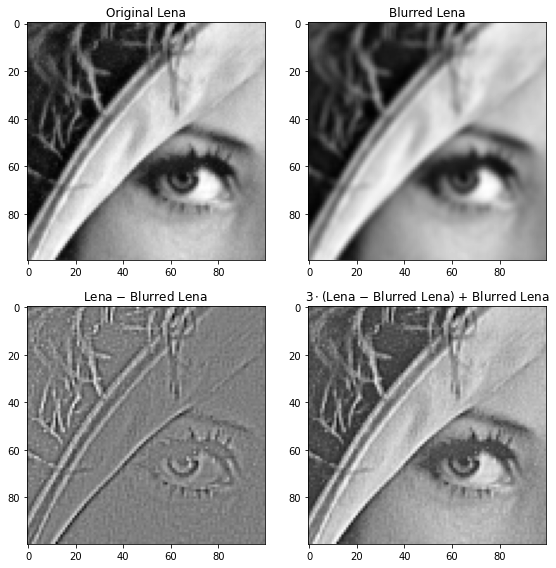

In [5]:
# Blurring and Sharpening the Lena by convolution

from scipy import signal

filter_size = 3
filter_blur = np.ones((filter_size, filter_size)) / filter_size**2
lena = lena()
blurred = signal.convolve2d(lena, filter_blur, boundary='symm', mode='same')

fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax[0, 0].imshow(lena[200:300, 200:300], cmap='gray')
ax[0, 0].set_title('Original Lena')
ax[0, 1].imshow(blurred[200:300, 200:300], cmap='gray')
ax[0, 1].set_title('Blurred Lena')
ax[1, 0].imshow((lena - blurred)[200:300, 200:300], cmap='gray')
ax[1, 0].set_title('Lena $-$ Blurred Lena')
ax[1, 1].imshow(((lena - blurred)*3 + blurred)[200:300, 200:300], cmap='gray')
ax[1, 1].set_title('$3\cdot$(Lena $-$ Blurred Lena) + Blurred Lena')
fig.tight_layout()

## Conclusions

* For big matrices $\mathcal{O}(n^2)$ is very time-consuming
* Can be better for special types of matrices